# Building the car classifier

## Prepare the data set

In [1]:
import glob
import cv2
from skimage import img_as_float
import numpy as np
from tqdm import tqdm
s_test_data_dir = './training_data/'

def get_data_list(dirs):
    """
    :param dirs: the directory that will be recursively eximined for images
    :return: list of tuples file name and class index 1 is a car , 0 is not a car
    """
    images_cars = glob.glob(dirs+'vehicles/**/*.png',recursive=True)
    images_non_cars = glob.glob(dirs+'non-vehicles/**/*.png',recursive=True)
    assert  len(images_cars) !=0, 'No car images'
    assert  len(images_non_cars)!=0, 'No non car images'
    samples_list = []
    for file in images_cars:
            samples_list.append((file, 1))
    for file in images_non_cars:
            samples_list.append((file, 0))
    return samples_list

def augment_data_list(data_list, augment_list):
    """
    :data_list: list of tuples file name and class index 
    :augment_list: list of process functors can be used for data augmenation
    :return: list of tuples file name, class, functor
    """
    samples_list = []
    for file, iscar in data_list:
        for aug in augment_list:
            samples_list.append((file, iscar, aug))
    return samples_list

def generator(samples, batch_size=None):
    """
    :param samples: list of tuples file name, class, functor
    :param batch_size: number of images to return each iteration
    :return: tuple of 4D image array (batch, height, width, channels) and class
    Note: The image is loaded from file converted to RGB float32 and functor is applied
    """
    num_samples = len(samples)
    if batch_size is None:
        batch_size = num_samples
    while 1:  # Loop forever so the generator never terminates
        samples = shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]
            images = []
            i_class = []
            for file_name, is_car, aug in batch_samples:
                image_orig = img_as_float(cv2.cvtColor(cv2.imread(file_name),cv2.COLOR_BGR2RGB))
                image_orig = image_orig.astype(np.float32)
                images.append(aug(image_orig))
                i_class.append(is_car)
            x_data = np.array(images)
            y_data = np.array(i_class)
            yield shuffle(x_data, y_data)

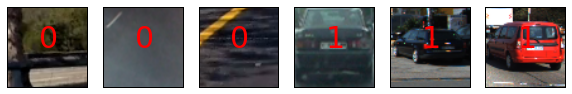

Number of car  images  8792
Number of other images  8968
Dimentions of an image (64, 64, 3)
Data type of an image float32


In [2]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
# Visualizations will be shown in the notebook.
%matplotlib inline 
def showUnique(images, labels):
    unique_lables = np.unique(labels)
    image_list =[]
    for label in unique_lables:
        for i in range(3):
            image_list.append((images[labels==label][i],label))
    fig = plt.figure(figsize=(10, 15))
    for image_index in range(len(image_list)):
        ax = fig.add_subplot(8,6,image_index+1)
        image_name = image_index
        image, label = image_list[image_index]
        plt.imshow(image)
        ax.text(25, 32, '{:1.0f}'.format(label), fontsize=30,color='red')
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticks([])
        plt.savefig('./output_images/data_set_examples.png', bbox_inches='tight')
    plt.show()
def test():
    data_list = get_data_list(s_test_data_dir)
    x_data, y_data = next(generator(augment_data_list(data_list,[lambda x:x]),50))
    showUnique(x_data, y_data)
    print("Number of car  images ", len(glob.glob(s_test_data_dir+'vehicles/**/*.png',recursive=True)))
    print("Number of other images ", len(glob.glob(s_test_data_dir+'non-vehicles/**/*.png',recursive=True)))
    print("Dimentions of an image", x_data[0].shape)
    print("Data type of an image", x_data[0].dtype)
test()

## Define support funciton for feature extraction

In [3]:
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    """
    change color space of the image
    """
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """
    extract HOG featrues using square window
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    """
    downsample the image to create a spacial color-feature vector
    """
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    
    """
    compuate histogram to create space invariant features
    """
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

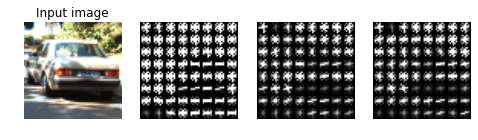

In [4]:
from skimage import data, color, exposure
def test():
    data_list = get_data_list(s_test_data_dir)
    x_data, y_data = next(generator(augment_data_list(data_list,[lambda x:x]),50)) 
    img = x_data[y_data == 1,:,:,:][0,:,:,:]
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=True)
    ax1.imshow(img, cmap=plt.cm.gray)
    ax1.set_title('Input image')
    ax1.axis('off')
    ax1.set_adjustable('box-forced')
    orient=9
    pix_per_cell=8
    cell_per_block=2
    img=convert_color(img)
    fd, hog_image0 = get_hog_features(img[:,:,0], orient, pix_per_cell,cell_per_block, True)
    fd, hog_image1 = get_hog_features(img[:,:,1], orient, pix_per_cell,cell_per_block, True)
    fd, hog_image2 = get_hog_features(img[:,:,2], orient, pix_per_cell,cell_per_block, True)

    hog_image0 = exposure.rescale_intensity(hog_image0, in_range=(0, 0.02))
    ax2.axis('off')
    ax2.imshow(hog_image0, cmap=plt.cm.gray)
    ax2.set_adjustable('box-forced')
    
    hog_image1 = exposure.rescale_intensity(hog_image1, in_range=(0, 0.02))
    ax3.axis('off')
    ax3.imshow(hog_image1, cmap=plt.cm.gray)
    ax3.set_adjustable('box-forced')
    hog_image2 = exposure.rescale_intensity(hog_image2, in_range=(0, 0.02))
    ax4.axis('off')
    ax4.imshow(hog_image2, cmap=plt.cm.gray)
    ax4.set_adjustable('box-forced')
    plt.show()
    fig.savefig("./output_images/hog_feature.png", bbox_inches='tight')
test()

In [5]:

def extract_features(image, conv='RGB2YCrCb', hog_channel='ALL', orient=9,
                     pix_per_cell=8, cell_per_block=2,
                     spatial_size = 0, hist_bins = 0):
    """
    concatincataed feature vector 
    HOG features from all channels
    color-space feature vector
    color feature vector
    """
    features = []
    feature_image = convert_color(image,conv)
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    features.append(hog_features)
        #3) Compute spatial features if flag is set
    if spatial_size != 0:
        spatial_features = bin_spatial(feature_image, size=(spatial_size,spatial_size))
        #4) Append features to list
        features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_bins != 0:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        features.append(hist_features)
    # Return list of feature vectors
    return np.concatenate(features)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import os
import pickle
import os.path
from sklearn.utils import shuffle
def train_classifier(file_name):
    """
    :param file_name: location where the classifier is stored
    :returns: dictionary with classifier, scaler, and parametes of feature extraction
    If file is not present the classifier is trained and the stored
    Train calssifier and store the result in the file
    """
    color_space='RGB2YCrCb'
    hog_channel='ALL'
    orient=9
    pix_per_cell=8
    cell_per_block=2
    spatial_size = 32
    hist_bins = 32
    data_list = get_data_list(s_test_data_dir)
    train_list, valid_list = train_test_split(data_list,
                                              test_size=0.2,
                                              random_state=np.random.randint(0, 100))
    e_features = lambda img: extract_features(img,
                                    conv=color_space, 
                                    hog_channel=hog_channel,
                                    orient=orient,
                                    pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block,
                                    spatial_size=spatial_size,
                                    hist_bins=hist_bins)
    if os.path.isfile(file_name+".p"):
        x_valid, y_valid = next(generator(augment_data_list(valid_list,[e_features])))
        classifer_pickle = pickle.load(open(file_name+".p", "rb" ))
        print( 'Using:', orient,
        'orientations', pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
        print('Feature vector length:', len(x_valid[0]))
        x_valid = classifer_pickle["scaler"].transform(x_valid)
        print('Test Accuracy of SVC = ', round(classifer_pickle["classifier"].score(x_valid, y_valid), 4))
        print('Test Accuracy is approximate as it is a random read out and will include  exampes from training set')
        return classifer_pickle
    else:
        
        print('Read out')
        x_train, y_train = next(generator(augment_data_list(train_list,[e_features])))
        x_valid, y_valid = next(generator(augment_data_list(y_valid,[e_features])))
        
        
        assert x_train.shape[0] == y_train.shape[0], 'something wrong'
        assert x_valid.shape[0] == y_valid.shape[0], 'something wrong'
        print('Normalize feature vector')
        
        X_scaler = StandardScaler().fit(x_train)
        x_train = X_scaler.transform(x_train)
        x_valid = X_scaler.transform(x_valid)

        print( 'Using:', orient,
                'orientations', pix_per_cell,
                'pixels per cell and', cell_per_block,'cells per block')
        print('Feature vector length:', len(x_train[0]))
        
        
        svc = LinearSVC()
        # Check the training time for the SVC
    
        print('Training ...')
        %time svc.fit(x_train, y_train)
        print('Testing ...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(svc.score(x_valid, y_valid), 4))
        # Check the prediction time for a single sample
        classifer_pickle = {}
        classifer_pickle["color_space"]    = color_space
        classifer_pickle["classifier"]     = svc
        classifer_pickle["scaler"]         = X_scaler
        classifer_pickle["orient"]         = orient
        classifer_pickle["pix_per_cell"]   = pix_per_cell
        classifer_pickle["cell_per_block"] = cell_per_block 
        classifer_pickle["spatial_size"]   = spatial_size 
        classifer_pickle["hist_bins"]      = hist_bins 
        pickle.dump(classifer_pickle, open(file_name + ".p", "wb"))
        return classifer_pickle

In [8]:
cl_d = train_classifier("./classifier_lin")

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
Test Accuracy of SVC =  0.9986
Test Accuracy is approximate as it is a random read out and will include  exampes from training set


In [51]:
def find_cars(img, ystart, ystop, stride,
              scale, color_space  ,svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    """
    the function to perform the sliding window search
    Based on the snippet provided in the Udacity lecture
    """
    assert np.max(img)<=1.0, "Not a scaled?"
    assert img.dtype != np.uint8, "Not a float?"
    img = img.astype(np.float32)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
   
    nxsteps = (nxblocks - nblocks_per_window) // stride
    nysteps = (nyblocks - nblocks_per_window) // stride
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*stride
            xpos = xb*stride
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=(spatial_size,spatial_size))
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return box_list

In [52]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1.0

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0.0
    # Return thresholded map
    return heatmap

def label2bboxes(labels):
    # Iterate through all detected cars
    box_list = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        box_list.append(bbox)
    return box_list

def draw_bboxes(img, bbox_list, color=(0, 0, 1.0)):
    # Iterate through all detected cars
    box_list = []
    for bbox in bbox_list:
        img = cv2.rectangle(img, bbox[0], bbox[1], color,6)
    return img

In [61]:
from skimage import img_as_ubyte
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

class Pipeline(object):
    def __init__(self):
        self.heat = None
    def process(self, img):
        img = img_as_float(img)
        ystart = 400
        ystop = 656
        param_list = [(400, 500, 3, 0.7),
                      (400, 500, 2, 1.0),
                      (400, 550, 2, 1.5),
                      (400, 600, 1, 2.0),
                      (400, 656, 1, 2.5),]
        
        out_class = np.copy(img)
        heatmap = np.zeros_like(img)
        if self.heat is None:
            self.heat = np.zeros_like(img[:,:,0])
        for  index, params in enumerate(param_list):
            ystart, ystop, stride, scale = params
            boxes = find_cars(img, ystart, ystop, stride, scale, cl_d["color_space"], cl_d["classifier"], 
                       cl_d["scaler"], cl_d["orient"], cl_d["pix_per_cell"], cl_d["cell_per_block"], 
                        cl_d["spatial_size"], cl_d["hist_bins"])
            color = [0.0, 0.0, 0.0]
            color[index% 3] = 1.0
            out_class = draw_bboxes(out_class, boxes,color)
            heatmap[:,:,index % 3] = add_heat(heatmap[:,:,index% 3], boxes)
            self.heat = self.heat + heatmap[:,:,index % 3]
       
        # Apply threshold to help remove false positives
        heat = apply_threshold(self.heat, 5)
        # Find final boxes from heatmap using label function
        labels = label(heat)
        final_box_list = label2bboxes(labels)
        out_bbox = draw_bboxes(np.copy(img),final_box_list)
        
        if np.max(heatmap)>1.0:
            heatmap = heatmap/np.max(heatmap)
        out_heat = weighted_img(heatmap,np.copy(img))
        out_heat = np.clip(out_heat,-1.0,1.0)
        out_img = img_as_ubyte(np.hstack((out_bbox, out_heat, out_class)))
        
        self.heat = np.zeros_like(img[:,:,0])
        self.heat = add_heat(self.heat, final_box_list)
        self.heat = add_heat(self.heat, final_box_list)
        self.heat = add_heat(self.heat, final_box_list)
        return out_img
def pipeline_test(img):
    return Pipeline().process(img)

# Run processing on test images

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.12s/it]


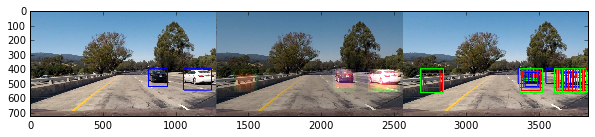

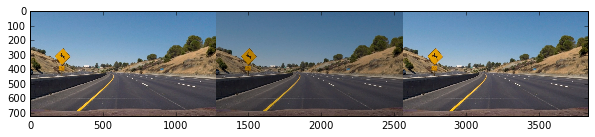

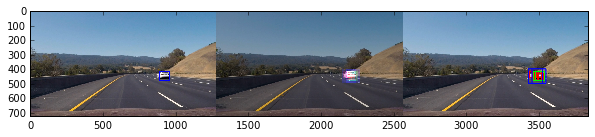

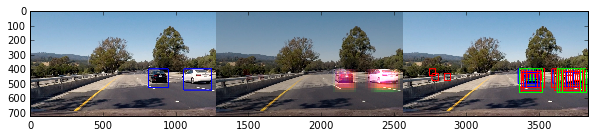

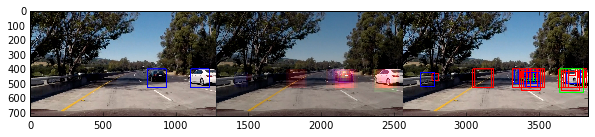

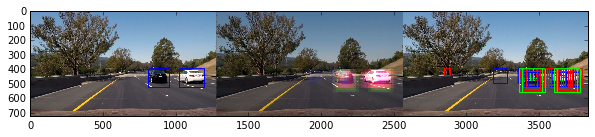

In [62]:
def output_images():
    # Test undistortion on an image
    dir_name = "./test_images"
    file_list = glob.glob(dir_name + "/*.jpg")
    image_list =[]
    for file_name in tqdm(file_list):
        img = cv2.cvtColor(cv2.imread(file_name),cv2.COLOR_BGR2RGB)
        fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
        ax1.imshow(pipeline_test(img))
        fig.savefig("./output_images/"+ file_name.split('\\')[-1], bbox_inches='tight')
output_images()

## Run processing on test videos

In [63]:
from moviepy.editor import VideoFileClip
def test_vid(image, funcs):
    vis = []
    for func in funcs:
        vis.append(func(image))
    result = np.concatenate(vis, axis=1)
    return result
def process_video(input_file):
    output_file = "./output_videos/" + input_file.split('/')[-1]
    print(output_file)
    clip1 = VideoFileClip(input_file, audio=False)
    print(output_file)
    pipe = Pipeline()
    output_clip = clip1.fl_image(pipe.process)
    output_clip.write_videofile(output_file, audio=False)

process_video("./test_videos/test_video.mp4")
process_video("./test_videos/project_video.mp4")

./output_videos/test_video.mp4
./output_videos/test_video.mp4
[MoviePy] >>>> Building video ./output_videos/test_video.mp4
[MoviePy] Writing video ./output_videos/test_video.mp4


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 38/39 [01:10<00:01,  1.82s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/test_video.mp4 

./output_videos/project_video.mp4
./output_videos/project_video.mp4
[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [36:55<00:01,  1.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video.mp4 

